In [5]:
import pandas as pd
import requests
from sklearn.cluster import KMeans
import folium
from os import path
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import numpy as np

In [6]:
#Read neighborhoods file
nb_df = pd.read_csv('LosAngeles.csv');
nb_df.head()

,Neighborhood,Link,Lat,Lon
0,Angelino Heights,https://en.wikipedia.org/wiki/Angelino_Heights...,34.070289,-118.254796
1,Arleta,"https://en.wikipedia.org/wiki/Arleta,_Los_Angeles",34.241327,-118.432205
2,Arlington Heights,https://en.wikipedia.org/wiki/Arlington_Height...,34.128557,-118.152999
3,Arts District,"https://en.wikipedia.org/wiki/Arts_District,_L...",34.041239,-118.234450
4,Atwater Village,"https://en.wikipedia.org/wiki/Atwater_Village,...",34.116398,-118.256464


In [7]:
#Get foursquare credentials from our configuration file
cred = pd.read_csv('fs_credentials.csv')
CLIENT_ID = cred['CLIENT_ID'][0]
CLIENT_SECRET = cred['CLIENT_SECRET'][0]

In [8]:
def searchVenues(neighborhood, lat, lon, query):
    VERSION = '20190722' 
    radius = 1000
    locale = 'en'
    LIMIT = 400
    url = "https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}&locale={}".format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT, query, locale)
    results = requests.get(url).json()["response"]['venues']
    res_venues = []
    for venue in results:
        if len(venue['categories']) > 0:
            res_venues.append([neighborhood,
                              #lat,
                              #lon,
                              venue['location']['lat'], 
                              venue['location']['lng'], 
                              venue['categories'][0]['name']])    
    return res_venues

In [9]:
#If we have previously saved venues into a file, load it and avoid invoking foursquare API
if path.exists('LosAngelesVenues.csv'):
    print('Reading venues from file')
    venues_df = pd.read_csv('LosAngelesVenues.csv')
else:
    print('Gathering venues from Foursquare API')
    #Compose a dataframe with all the venues
    venues = []
    count = 0;
    for index, row in nb_df.iterrows():
        count = count + 1;
        neighborhood = row['Neighborhood']
        lat = row['Lat']
        lon = row['Lon']
        venues = venues + searchVenues(neighborhood, lat, lon, 'restaurant')
        #if count == 6:
        #    break
    venues_df = pd.DataFrame(venues, columns=['Neighborhood','Lat','Lon','Type'])        
    venues_df.to_csv('LosAngelesVenues.csv', index=False)

Reading venues from file


In [54]:
#Remove any row that doesn't contain 'Restaurant' and those whos type is just 'Restaurant'
venues_df = venues_df[(venues_df['Type'].str.contains('Restaurant')) & (venues_df['Type'] != 'Restaurant')  & (venues_df['Lon'] < 0)]

In [55]:
#List different type of types
v_cnt_df = venues_df.groupby(['Type'])['Type'].count().reset_index(name="Count")
v_cnt_df.sort_values(by=['Count'], ascending=False, inplace=True)

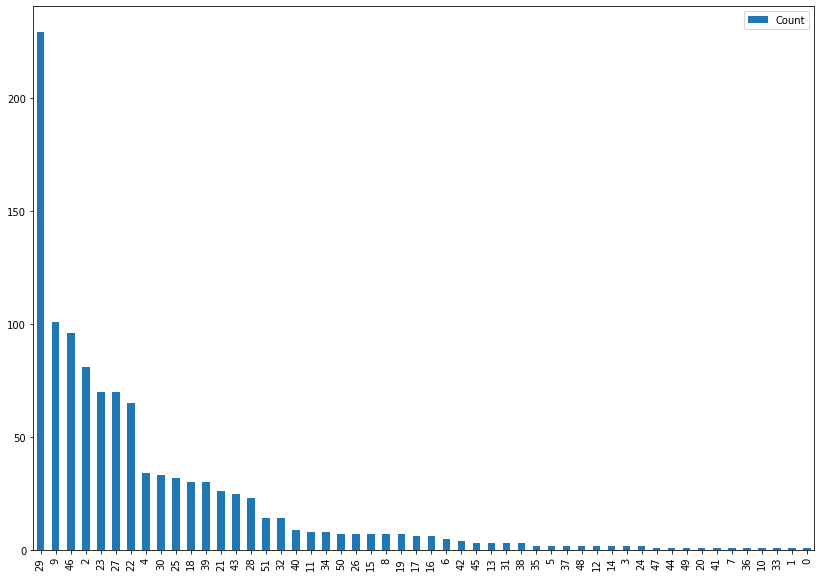

In [56]:
v_cnt_df.plot(kind='bar')

### We will focus on the seventh top food types
We assume that LA people prefer these kind of restaurants to the rest

In [57]:
top = 7

In [58]:
#Let's choose the top ten restaurant categories
top_types_df = pd.DataFrame({'Type':v_cnt_df['Type'].head(top)})

In [59]:
top_types_df.reset_index(inplace=True)
top_types_df.drop(columns='index', axis=1, inplace=True)
top_types_df

,Type
0,Mexican Restaurant
1,Chinese Restaurant
2,Thai Restaurant
3,American Restaurant
4,Japanese Restaurant
5,Latin American Restaurant
6,Italian Restaurant


## First map study (top food types)

In [60]:
#Select all venues that belong to top ten types
venues_in_top_df = venues_df[venues_df['Type'].isin(top_types_df['Type'])]

In [61]:
#Let's get Los Angeles coordinates
geolocator = Nominatim(user_agent="LosAngelesCrawler")
location = geolocator.geocode('Los Angeles, CA')
LALat = location.latitude
LALon = location.longitude

In [230]:
map_types = folium.Map(location=[LALat, LALon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(top)
ys = [i + x + (i*x)**2 for i in range(top)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, type in zip(venues_in_top_df['Lat'], venues_in_top_df['Lon'], venues_in_top_df['Type']):
    index = top_types_df.index[top_types_df['Type'] == type][0]
    label = folium.Popup('Type ' + type, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[index],
        #color=rainbow[5],
        fill=True,
        fill_color=rainbow[index],
        #fill_color=rainbow[3],
        fill_opacity=0.7).add_to(map_types)
       
map_types

### Group restaurants into clusters

In [82]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = venues_in_top_df[['Lat','Lon']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.05, min_samples=6).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
venues_in_top_df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


#venues_in_top_df["Clus_Db"].plot(kind='hist')

/home/aia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [274]:
map_types = folium.Map(location=[LALat, LALon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, Clus_Db in zip(venues_in_top_df['Lat'], venues_in_top_df['Lon'], venues_in_top_df['Clus_Db']):
    index = Clus_Db + 1
    label = folium.Popup('Cluster ' + str(Clus_Db), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[index],
        #color=rainbow[5],
        fill=True,
        fill_color=rainbow[index],
        #fill_color=rainbow[3],
        fill_opacity=0.7).add_to(map_types)
       
map_types

In [97]:
#Disregard outliers and cluster 0, and then group by Cluster and food type to get the count of each of them
clas_df = venues_in_top_df[venues_in_top_df['Clus_Db'] > 0].groupby(['Clus_Db', 'Type'])['Clus_Db'].count().reset_index(name="Count")

In [122]:
#Pivot our dtaframe
pivot_clas_df = clas_df.pivot(index='Type', columns='Clus_Db', values='Count')
#Add a total column
pivot_clas_df['Total'] = pivot_clas_df.sum(axis=1)
pivot_clas_df

Clus_Db,1,2,3,4,5,6,Total
Type,,,,,,,
American Restaurant,NaN,2.0,1.0,8.0,NaN,NaN,11.0
Chinese Restaurant,5.0,5.0,1.0,6.0,4.0,2.0,23.0
Italian Restaurant,1.0,2.0,1.0,9.0,NaN,1.0,14.0
Japanese Restaurant,NaN,1.0,NaN,2.0,1.0,NaN,4.0
Latin American Restaurant,6.0,NaN,NaN,2.0,NaN,2.0,10.0
Mexican Restaurant,9.0,8.0,2.0,10.0,7.0,1.0,37.0
Thai Restaurant,4.0,3.0,1.0,8.0,2.0,NaN,18.0


In [123]:
#We calculate now the total nomber of restaurants
total = pivot_clas_df['Total'].sum()
total

117.0

In [124]:
#And add a column to show the relevance of that food type vs total
pivot_clas_df['Relevance'] = pivot_clas_df['Total']/total
pivot_clas_df

Clus_Db,1,2,3,4,5,6,Total,Relevance
Type,,,,,,,,
American Restaurant,NaN,2.0,1.0,8.0,NaN,NaN,11.0,0.094017
Chinese Restaurant,5.0,5.0,1.0,6.0,4.0,2.0,23.0,0.196581
Italian Restaurant,1.0,2.0,1.0,9.0,NaN,1.0,14.0,0.119658
Japanese Restaurant,NaN,1.0,NaN,2.0,1.0,NaN,4.0,0.034188
Latin American Restaurant,6.0,NaN,NaN,2.0,NaN,2.0,10.0,0.085470
Mexican Restaurant,9.0,8.0,2.0,10.0,7.0,1.0,37.0,0.316239
Thai Restaurant,4.0,3.0,1.0,8.0,2.0,NaN,18.0,0.153846


In [130]:
cluster_totals_df = pivot_clas_df.sum(numeric_only=True).reset_index(name="Count")
cluster_totals_df

,Clus_Db,Count
0,1,25.0
1,2,21.0
2,3,6.0
3,4,45.0
4,5,14.0
5,6,6.0
6,Total,117.0
7,Relevance,1.0


In [231]:
#We calculate a matrix to show the relevance of the food type multiplied by the inverse of the relevance inside the cluster
res = []
for index, row in pivot_clas_df.iterrows():
    res_row = []
    res_row.append(index)
    for i in range(6):
        clTotal = cluster_totals_df[cluster_totals_df['Clus_Db']==(i+1)]['Count']
        res_row.append(1/(row[i+1] / clTotal[i])*row['Relevance'])
    res.append(res_row)
df1 = pd.DataFrame(res)
df1.fillna(0, inplace=True)
df1.rename(columns={0:'Type',1:'Cluster 1',2:'Cluster 2',3:'Cluster 3',4:'Cluster 4',5:'Cluster 5',6:'Cluster 6'}, inplace=True)
df1

,Type,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,American Restaurant,0.000000,0.987179,0.564103,0.528846,0.000000,0.000000
1,Chinese Restaurant,0.982906,0.825641,1.179487,1.474359,0.688034,0.589744
2,Italian Restaurant,2.991453,1.256410,0.717949,0.598291,0.000000,0.717949
3,Japanese Restaurant,0.000000,0.717949,0.000000,0.769231,0.478632,0.000000
4,Latin American Restaurant,0.356125,0.000000,0.000000,1.923077,0.000000,0.256410
5,Mexican Restaurant,0.878443,0.830128,0.948718,1.423077,0.632479,1.897436
6,Thai Restaurant,0.961538,1.076923,0.923077,0.865385,1.076923,0.000000


In [277]:
result = []
for i in range(6):
    cluster = "Cluster "+str(i+1)
    rtype = df1.sort_values(by=[cluster], ascending = False)['Type'].to_numpy()[0]
    weight = df1.sort_values(by=[cluster], ascending = False)[cluster].to_numpy()[0]
    result.append([cluster, rtype, weight])
result_df = pd.DataFrame(result)
result_df.rename(columns={0:'Cluster',1:'Food type', 2:'Weight'}, inplace=True)
result_df

,Cluster,Food type,Weight
0,Cluster 1,Italian Restaurant,2.991453
1,Cluster 2,Italian Restaurant,1.256410
2,Cluster 3,Chinese Restaurant,1.179487
3,Cluster 4,Latin American Restaurant,1.923077
4,Cluster 5,Thai Restaurant,1.076923
5,Cluster 6,Mexican Restaurant,1.897436
